  0%|          | 0/176 [00:00<?, ?it/s]

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 1.0835 - mae: 1.0399

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


11/11 [==============================] - 5s 147ms/step - loss: 1.0835 - mae: 1.0399 - lr: 1.0000e-04
Epoch 2/50
11/11 [==============================] - 2s 139ms/step - loss: 0.9783 - mae: 0.9237 - lr: 1.0000e-04
Epoch 3/50
11/11 [==============================] - 2s 146ms/step - loss: 0.8204 - mae: 0.7197 - lr: 1.0000e-04
Epoch 4/50
11/11 [==============================] - 2s 168ms/step - loss: 0.8036 - mae: 0.7081 - lr: 1.0000e-04
Epoch 5/50
11/11 [==============================] - 2s 146ms/step - loss: 0.7877 - mae: 0.6952 - lr: 1.0000e-04
Epoch 6/50
11/11 [==============================] - 2s 139ms/step - loss: 0.7850 - mae: 0.7162 - lr: 1.0000e-04
Epoch 7/50
11/11 [==============================] - 2s 147ms/step - loss: 0.7727 - mae: 0.6848 - lr: 1.0000e-04
Epoch 8/50
11/11 [==============================] - 1s 125ms/step - loss: 0.7637 - mae: 0.6954 - lr: 1.0000e-04
Epoch 9/50
11/11 [==============================] - 1s 114ms/step - loss: 0.7648 - mae: 0.7056 - lr: 1.0000e-04
Epo

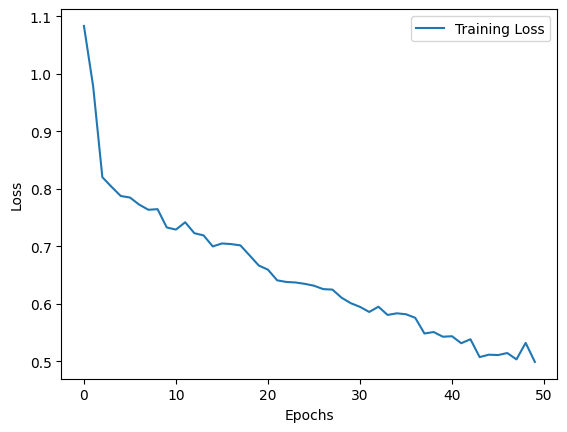

In [52]:
import os
import numpy as np
import pandas as pd
import cv2
import pydicom
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Reshape, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

EPOCHS = 50
BATCH_SIZE = 16
LR = 1e-4 
SEQ_LENGTH = 10
IMG_SIZE = (128, 128)
train_df = pd.read_csv('/kaggle/input/osic-pulmonary-fibrosis-progression/train.csv')

def get_tab(df):
    age = (df.Age.values[0] - 30) / 30
    sex = 0 if df.Sex.values[0].lower() == 'male' else 1
    smoking = [0, 0] if df.SmokingStatus.values[0] == 'Never smoked' else [1, 0] if df.SmokingStatus.values[0] == 'Ex-smoker' else [0, 1]
    return np.array([age, sex] + smoking)

A = {}
TAB = {}
SEQUENCES = {}
P = []
for patient_id in tqdm(train_df.Patient.unique()):
    sub_df = train_df[train_df.Patient == patient_id]
    fvc = sub_df.FVC.values
    weeks = sub_df.Weeks.values
    coeff = np.linalg.lstsq(np.vstack([weeks, np.ones(len(weeks))]).T, fvc, rcond=None)[0]
    A[patient_id] = coeff[0] 
    TAB[patient_id] = get_tab(sub_df) 
    SEQUENCES[patient_id] = np.column_stack((weeks, fvc))
    P.append(patient_id)

fvc_values = np.array(list(A.values())).reshape(-1, 1)
scaler_fvc = StandardScaler()
fvc_scaled = scaler_fvc.fit_transform(fvc_values).flatten()

def get_img(path):
    dicom_data = pydicom.dcmread(path)
    img = (dicom_data.pixel_array - dicom_data.RescaleIntercept) / (dicom_data.RescaleSlope * 1000)
    img_resized = cv2.resize(img, IMG_SIZE)
    img_gray = np.expand_dims(img_resized, axis=-1)
    return img_gray

class DataGenerator(Sequence):
    def __init__(self, patient_ids, labels, batch_size=BATCH_SIZE, img_dir='/kaggle/input/osic-pulmonary-fibrosis-progression/train', img_size=IMG_SIZE):
        self.patient_ids = [p for p in patient_ids if p not in ['ID00011637202177653955184', 'ID00052637202186188008618']]
        self.labels = labels
        self.batch_size = batch_size
        self.img_dir = img_dir
        self.img_size = img_size
        self.indices = np.arange(len(self.patient_ids))
        self.train_data = {p: os.listdir(f'{self.img_dir}/{p}/') for p in self.patient_ids}

    def __len__(self):
        return int(np.ceil(len(self.labels) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_patient_ids = [self.patient_ids[i] for i in batch_indices]
        batch_labels = self.labels[batch_indices]
        img_batch = np.array([self.load_image(pid) for pid in batch_patient_ids])
        tab_batch = np.array([TAB[pid] for pid in batch_patient_ids])
        seq_batch = [SEQUENCES[pid] for pid in batch_patient_ids]                                          
        seq_batch = pad_sequences(seq_batch, maxlen=SEQ_LENGTH, dtype='float32', padding='post', truncating='post')
        return [img_batch, tab_batch, seq_batch], batch_labels

    def load_image(self, patient_id):
        img_dir = os.path.join(self.img_dir, patient_id)
        img_files = os.listdir(img_dir)
        img_file = np.random.choice(img_files)
        img_path = os.path.join(img_dir, img_file)
        return get_img(img_path)

def build_cnn_lstm_model(image_shape=(128, 128, 1), lstm_input_shape=(None, 2)):
    inp_img = Input(shape=image_shape)
    x_img = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(inp_img)
    x_img = MaxPooling2D((2, 2))(x_img)
    x_img = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(x_img)
    x_img = MaxPooling2D((2, 2))(x_img)
    x_img = Flatten()(x_img)
    inp_tab = Input(shape=(4,))
    x_tab = BatchNormalization()(inp_tab)
    x_tab = Dropout(0.3)(x_tab)
    inp_seq = Input(shape=lstm_input_shape)
    x_seq = LSTM(128, return_sequences=False)(inp_seq)
    x = tf.keras.layers.Concatenate()([x_img, x_tab, x_seq])
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(1)(x)
    model = Model([inp_img, inp_tab, inp_seq], x)
    return model

cnn_lstm_model = build_cnn_lstm_model()
cnn_lstm_model.compile(optimizer=Adam(learning_rate=LR), loss=tf.keras.losses.Huber(), metrics=['mae'])
train_generator = DataGenerator(train_df.Patient.unique(), fvc_scaled, batch_size=BATCH_SIZE)
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='cnn_lstm_model_best.h5', monitor='loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)
cnn_lstm_history = cnn_lstm_model.fit(train_generator, epochs=EPOCHS, callbacks=[early_stop, checkpoint, lr_scheduler])
plt.plot(cnn_lstm_history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
cnn_lstm_model.save('cnn_lstm_model.h5')


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 1s 517ms/step - loss: 1.1436 - mae: 1.3842


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 385ms/step
Test Mean Absolute Error (MAE): 1.3722359781124376


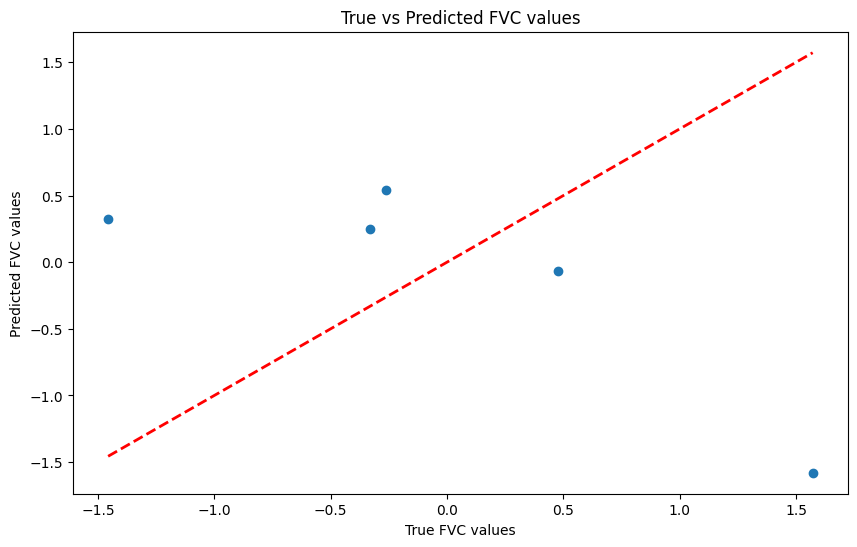

In [53]:
import numpy as np
import os
import pandas as pd
import cv2
import pydicom
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence

cnn_lstm_model = load_model('cnn_lstm_model_best.h5')

test_df = pd.read_csv('/kaggle/input/osic-pulmonary-fibrosis-progression/test.csv')

def get_tab(df):
    age = (df.Age.values[0] - 30) / 30
    sex = 0 if df.Sex.values[0].lower() == 'male' else 1
    smoking = [0, 0] if df.SmokingStatus.values[0] == 'Never smoked' else [1, 0] if df.SmokingStatus.values[0] == 'Ex-smoker' else [0, 1]
    return np.array([age, sex] + smoking)

A_test = {}
TAB_test = {}
SEQUENCES_test = {}
P_test = []

for patient_id in tqdm(test_df.Patient.unique()):
    sub_df = test_df[test_df.Patient == patient_id]
    fvc = sub_df.FVC.values
    weeks = sub_df.Weeks.values
    coeff = np.linalg.lstsq(np.vstack([weeks, np.ones(len(weeks))]).T, fvc, rcond=None)[0]
    A_test[patient_id] = coeff[0]
    TAB_test[patient_id] = get_tab(sub_df)
    SEQUENCES_test[patient_id] = np.column_stack((weeks, fvc))
    P_test.append(patient_id)

fvc_values_test = np.array(list(A_test.values())).reshape(-1, 1)
scaler_fvc_test = StandardScaler()
fvc_scaled_test = scaler_fvc_test.fit_transform(fvc_values_test).flatten()

def get_img(path):
    dicom_data = pydicom.dcmread(path)
    img = (dicom_data.pixel_array - dicom_data.RescaleIntercept) / (dicom_data.RescaleSlope * 1000)
    img_resized = cv2.resize(img, (128, 128))
    img_gray = np.expand_dims(img_resized, axis=-1)
    return img_gray

class DataGeneratorTest(Sequence):
    def __init__(self, patient_ids, labels, batch_size=16, img_dir='/kaggle/input/osic-pulmonary-fibrosis-progression/train', img_size=(128, 128)):
        self.patient_ids = patient_ids
        self.labels = labels
        self.batch_size = batch_size
        self.img_dir = img_dir
        self.img_size = img_size
        self.indices = np.arange(len(self.patient_ids))

    def __len__(self):
        return int(np.ceil(len(self.labels) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_patient_ids = [self.patient_ids[i] for i in batch_indices]
        batch_labels = self.labels[batch_indices]

        img_batch = np.array([self.load_image(pid) for pid in batch_patient_ids])
        tab_batch = np.array([TAB_test[pid] for pid in batch_patient_ids])
        seq_batch = [SEQUENCES_test[pid] for pid in batch_patient_ids]
        seq_batch = pad_sequences(seq_batch, maxlen=10, dtype='float32', padding='post', truncating='post')

        return [img_batch, tab_batch, seq_batch], batch_labels

    def load_image(self, patient_id):
        img_dir = os.path.join(self.img_dir, patient_id)
        img_files = os.listdir(img_dir)
        img_file = np.random.choice(img_files)
        img_path = os.path.join(img_dir, img_file)
        return get_img(img_path)

test_generator = DataGeneratorTest(test_df.Patient.unique(), fvc_scaled_test, batch_size=16)

test_loss, test_mae = cnn_lstm_model.evaluate(test_generator, verbose=1)

y_true = []
y_pred = []

for batch in tqdm(test_generator):
    x_data, y_data = batch
    predictions = cnn_lstm_model.predict(x_data)
    y_true.extend(y_data)
    y_pred.extend(predictions.flatten())

mae = mean_absolute_error(y_true, y_pred)
print(f'Test Mean Absolute Error (MAE): {mae}')

plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
plt.xlabel('True FVC values')
plt.ylabel('Predicted FVC values')
plt.title('True vs Predicted FVC values')
plt.show()


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Concatenate
)
from tensorflow.keras.models import Model

# CNN Branch
def build_cnn_branch(input_shape):
    cnn_input = Input(shape=input_shape, name="CNN_Input")
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(cnn_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    cnn_output = Dense(128, activation="relu", name="CNN_Output")(x)
    return Model(inputs=cnn_input, outputs=cnn_output, name="CNN_Branch")

def build_lstm_branch(input_shape):
    lstm_input = Input(shape=input_shape, name="LSTM_Input")
    x = LSTM(128, return_sequences=True)(lstm_input)
    x = LSTM(64)(x)
    lstm_output = Dense(64, activation="relu", name="LSTM_Output")(x)
    return Model(inputs=lstm_input, outputs=lstm_output, name="LSTM_Branch")

def build_hybrid_model(cnn_input_shape, lstm_input_shape):
    cnn_branch = build_cnn_branch(cnn_input_shape)
    lstm_branch = build_lstm_branch(lstm_input_shape)

    combined = Concatenate()([cnn_branch.output, lstm_branch.output])
    x = Dense(128, activation="relu")(combined)
    x = Dropout(0.3)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation="linear", name="Output")(x)

    model = Model(inputs=[cnn_branch.input, lstm_branch.input], outputs=output, name="Hybrid_Model")
    return model

cnn_input_shape = (128, 128, 1)
lstm_input_shape = (10, 8)

model = build_hybrid_model(cnn_input_shape, lstm_input_shape)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

model.summary()

Model: "Hybrid_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 CNN_Input (InputLayer)      [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 128, 128, 32)         320       ['CNN_Input[0][0]']           
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)           0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 64, 64, 64)           18496     ['max_pooling2d_3[0